# Statistical Summary of Numerical Variables


In [ ]:
# Import libraries

    
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Attempt to import category_encoders for Binary and Target encoding, install if missing
try:
    import category_encoders as ce
except Exception:
    import sys
    !{sys.executable} -m pip install category_encoders
    import category_encoders as ce
#D:\Kamaliza_ML\

In [15]:
data_path = r'D:\Denise\Housing.xls'
alt_csv = r'house.csv'
if not os.path.exists(data_path) and os.path.exists(alt_csv):
    data_path = alt_csv
    print(f'Housing.xls not found — falling back to CSV at {data_path}')
else:
    print('Using dataset at:', data_path)

Using dataset at: D:\Kamaliza_ML\Housing.xls


In [16]:
# Load dataset robustly; detect CSV saved as .xls and choose appropriate reader
na_vals = ['None', 'none', 'NONE', 'NaN', 'nan', 'NA', 'N/A', 'n/a', '']

def is_likely_csv_file(path, head_bytes=2048):
    try:
        with open(path, 'rb') as f:
            head = f.read(head_bytes)
        # Binary signatures for typical Excel workbooks:
        if head.startswith(b'PK') or head.startswith(b'\xD0\xCF'):
            return False
        # If readable as text, check for comma-delimited structure heuristic
        try:
            head_text = head.decode('utf-8')
        except UnicodeDecodeError:
            return False
        # CSV heuristics: many commas and newlines relative to tabs
        if head_text.count(',') >= 2 and head_text.count('\n') >= 1 and head_text.count('\t') < head_text.count(','):
            return True
    except Exception:
        pass
    return False

try:
    file_ext = os.path.splitext(data_path)[1].lower()
    # If file looks text/CSV even with .xls/.xlsx, read as CSV
    if os.path.exists(data_path) and is_likely_csv_file(data_path):
        df = pd.read_csv(data_path, na_values=na_vals)
        print('Detected CSV-like content; loaded via read_csv')
    else:
        if file_ext in ('.xls', '.xlsx'):
            # Choose engine by extension, prefer engines and fallback to read_csv
            excel_engines = ['xlrd', 'openpyxl'] if file_ext == '.xls' else ['openpyxl', 'xlrd']
            loaded = False
            last_error = None
            for eng in excel_engines:
                try:
                    df = pd.read_excel(data_path, engine=eng)
                    print(f'Loaded dataset via read_excel (engine={eng})')
                    loaded = True
                    break
                except Exception as e:
                    last_error = e
            if not loaded:
                print('read_excel attempts failed — trying read_csv fallback. Last error:', last_error)
                try:
                    # Try to read as CSV with automatic separator detection
                    df = pd.read_csv(data_path, sep=None, engine='python', na_values=na_vals)
                    print('Loaded dataset via read_csv (fallback)')
                except Exception as e:
                    print('CSV fallback failed — raising error:', e)
                    raise
        else:
            # Non-excel extension — read with csv reader
            df = pd.read_csv(data_path, na_values=na_vals)
            print('Loaded dataset via read_csv (non-excel ext)')
except Exception as e:
    print('Failed to read dataset at:', data_path, ' — error:', e)
    raise

# Normalize textual tokens that represent missing values and trim strings
df.replace(['None', 'none', 'NONE', 'NaN', 'nan', 'NA', 'N/A', 'n/a'], np.nan, inplace=True)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.strip()

print('Data loaded — first 10 rows (before any transformations):')
df.head(10)
print('\nDataset shape:', df.shape)
print('\nMissing per column:')
print(df.isnull().sum())

Detected CSV-like content; loaded via read_csv
Data loaded — first 10 rows (before any transformations):

Dataset shape: (545, 13)

Missing per column:
price               0
area                3
bedrooms            0
bathrooms           1
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [17]:
# Quick info and dtypes
df.info()
print('\nData types:')
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             545 non-null    int64  
 1   area              542 non-null    float64
 2   bedrooms          545 non-null    int64  
 3   bathrooms         544 non-null    float64
 4   stories           545 non-null    int64  
 5   mainroad          545 non-null    object 
 6   guestroom         545 non-null    object 
 7   basement          545 non-null    object 
 8   hotwaterheating   545 non-null    object 
 9   airconditioning   545 non-null    object 
 10  parking           545 non-null    int64  
 11  prefarea          545 non-null    object 
 12  furnishingstatus  545 non-null    object 
dtypes: float64(2), int64(4), object(7)
memory usage: 55.5+ KB

Data types:


price                 int64
area                float64
bedrooms              int64
bathrooms           float64
stories               int64
mainroad             object
guestroom            object
basement             object
hotwaterheating      object
airconditioning      object
parking               int64
prefarea             object
furnishingstatus     object
dtype: object

In [18]:
# 1. Statistical Summary for numerical variables (including extra metrics)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
stats_df = df[num_cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
stats_df['skew'] = df[num_cols].skew()
stats_df['kurtosis'] = df[num_cols].kurtosis()
stats_df

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skew,kurtosis
price,545.0,4.766729e+06,1.870440e+06,1750000.0,1870400.0,2450000.0,3430000.0,4340000.0,5740000.0,8400000.0,10542000.0,13300000.0,1.212239,1.960130
area,542.0,5.127168e+03,2.143733e+03,1650.0,1970.5,2553.0,3588.0,4540.0,6360.0,8998.0,11831.7,16200.0,1.308216,2.755046
bedrooms,545.0,3.691743e+00,1.702314e+01,1.0,2.0,2.0,2.0,3.0,3.0,4.0,5.0,400.0,23.279477,542.949099
bathrooms,544.0,1.284926e+00,5.019967e-01,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0,1.599262,2.203253
stories,545.0,1.805505e+00,8.674925e-01,1.0,1.0,1.0,1.0,2.0,2.0,4.0,4.0,4.0,1.082088,0.679404
parking,545.0,6.935780e-01,8.615858e-01,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,0.842062,-0.573063


# Handling Missing Error

In [19]:
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing>0]

area         3
bathrooms    1
dtype: int64

In [20]:
# Show rows with missing area before imputation (before view)
df[df['area'].isnull()]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
3,12215000,NaN,4,2.0,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,NaN,4,1.0,2,yes,yes,yes,no,yes,2,no,furnished
10,9800000,NaN,3,1.0,2,yes,no,yes,no,yes,2,yes,furnished


In [21]:
# Impute missing 'area' and 'bedrooms' with median (explain in notebook markdown as done previously)
area_median = df['area'].median()
print('Area median:', area_median)
df['area_imputed'] = df['area'].fillna(area_median)
# Keep original area but create new column to track imputation; pass forward imputed column to work on.
df['area'] = df['area_imputed']
df.drop(columns=['area_imputed'], inplace=True)

# Impute bedrooms (for flagged NaNs and missing values) with median
bedrooms_median = df['bedrooms'].median()
print('Bedrooms median:', bedrooms_median)
df['bedrooms_imputed'] = df['bedrooms'].fillna(bedrooms_median)
df['bedrooms'] = df['bedrooms_imputed']
df.drop(columns=['bedrooms_imputed'], inplace=True)

print('After imputation — missing counts:')
df.isnull().sum()

Area median: 4540.0
Bedrooms median: 3.0
After imputation — missing counts:


price               0
area                0
bedrooms            0
bathrooms           1
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

# Duplicate Records

In [22]:
# Detect duplicates (full row duplicates). If duplicates found, decide to drop since exact repeats are not informative.
dupes = df.duplicated(keep=False)
print('Duplicate rows found:', df[dupes].shape[0])
df[dupes].head(10)

Duplicate rows found: 0


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus


In [23]:
# Drop exact duplicates (if any) and show count after removal
before_count = df.shape[0]
df = df.drop_duplicates(keep='first').reset_index(drop=True)
after_count = df.shape[0]
print(f'Rows removed: {before_count - after_count}')

Rows removed: 0


In [24]:
# Track unique values of categorical fields before cleaning
cat_cols = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea','furnishingstatus']
for c in cat_cols:
    print(c, '->', df[c].unique())

mainroad -> ['yes' 'no']
guestroom -> ['no' 'yes']
basement -> ['no' 'yes']
hotwaterheating -> ['no' 'yes']
airconditioning -> ['yes' 'no']
prefarea -> ['yes' 'no']
furnishingstatus -> ['furnished' 'semi-furnished' 'unfurnished']


In [25]:
# Clean string categories: strip & lower-case
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip().str.lower().replace({'none':'no', 'nan':'no'})

# Convert yes/no columns to 1/0 for binary flags
binary_cols = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']
for c in binary_cols:
    df[c + '_bin'] = df[c].map({'yes':1, 'no':0}).astype(int)

print('Unique values after cleaning and binary mapping:')
for c in cat_cols:
    print(c, '->', df[c].unique())

Unique values after cleaning and binary mapping:
mainroad -> ['yes' 'no']
guestroom -> ['no' 'yes']
basement -> ['no' 'yes']
hotwaterheating -> ['no' 'yes']
airconditioning -> ['yes' 'no']
prefarea -> ['yes' 'no']
furnishingstatus -> ['furnished' 'semi-furnished' 'unfurnished']


In [26]:
# Convert numeric columns that may have been read incorrectly (convert errors -> NaN)
num_cols_expected = ['price','area','bedrooms','bathrooms','stories','parking']
for c in num_cols_expected:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Detect unrealistic values and mark as NaN for cleaning/imputation
# Bedrooms: values > 20 are highly likely to be erroneous (e.g., 400 in provided dataset)
bedrooms_bad = (df['bedrooms'] > 20).sum()
if bedrooms_bad > 0:
    print(f'Found {bedrooms_bad} unrealistic bedroom value(s) (>20). Marking as NaN)')
    df.loc[df['bedrooms'] > 20, 'bedrooms'] = np.nan

# Stories: values > 10 unlikely; mark as NaN
stories_bad = (df['stories'] > 10).sum()
if stories_bad > 0:
    print(f'Found {stories_bad} unrealistic stories value(s) (>10). Marking as NaN)')
    df.loc[df['stories'] > 10, 'stories'] = np.nan

# Bathrooms & Parking: reasonable upper bounds - mark egregious values as NaN
bathrooms_bad = (df['bathrooms'] > 10).sum()
if bathrooms_bad > 0:
    print(f'Found {bathrooms_bad} unrealistic bathrooms value(s) (>10). Marking as NaN)')
    df.loc[df['bathrooms'] > 10, 'bathrooms'] = np.nan
parking_bad = (df['parking'] > 6).sum()
if parking_bad > 0:
    print(f'Found {parking_bad} unrealistic parking value(s) (>6). Marking as NaN)')
    df.loc[df['parking'] > 6, 'parking'] = np.nan

df[num_cols_expected].info()

Found 1 unrealistic bedroom value(s) (>20). Marking as NaN)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      545 non-null    int64  
 1   area       545 non-null    float64
 2   bedrooms   544 non-null    float64
 3   bathrooms  544 non-null    float64
 4   stories    545 non-null    int64  
 5   parking    545 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 25.7 KB


# OUTLIER DETECTION& Handling

In [28]:
# IQR method to detect outliers for price and area
def iqr_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

for col in ['price','area']:
    lower, upper = iqr_outliers(df[col])
    outliers = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    print(f'{col} IQR bounds: {lower:.2f} - {upper:.2f} — outliers: {outliers}')

price IQR bounds: -35000.00 - 9205000.00 — outliers: 15
area IQR bounds: -540.00 - 10500.00 — outliers: 11


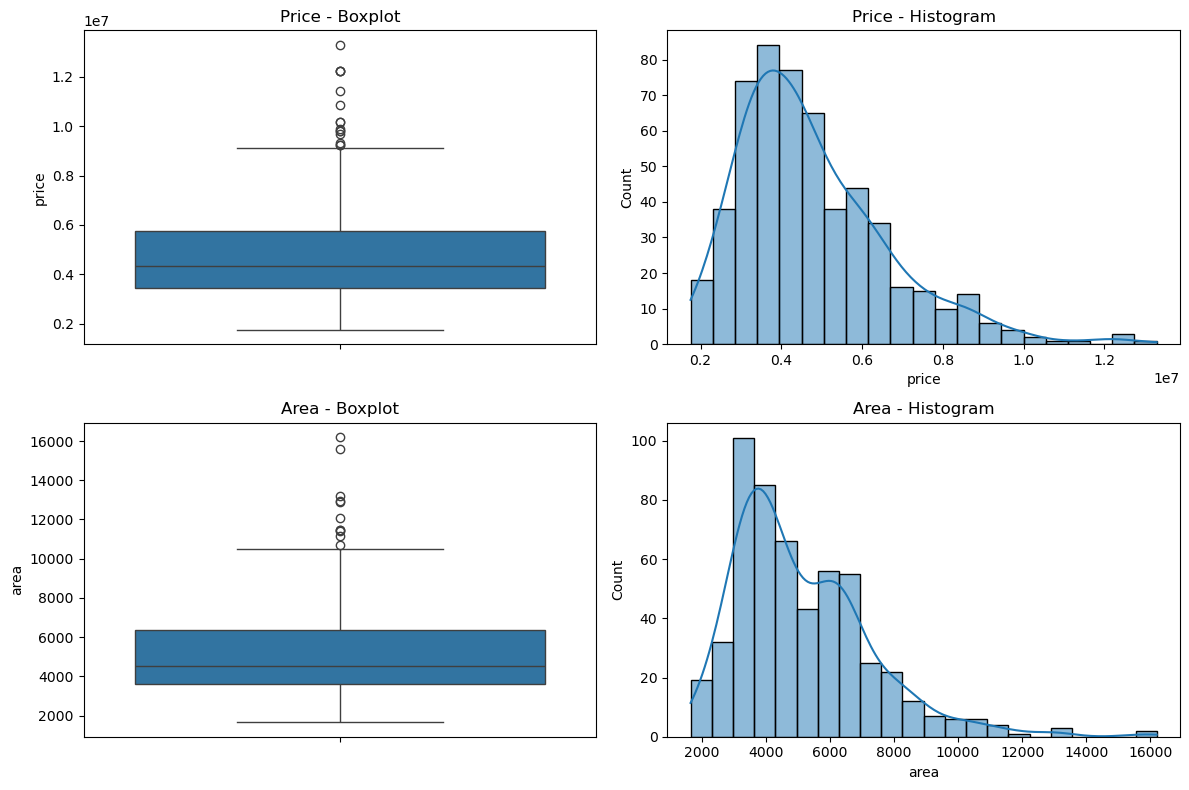

In [29]:
# Visualize price and area distributions with boxplots and histograms
fig, axes = plt.subplots(2,2,figsize=(12,8))
sns.boxplot(df['price'], ax=axes[0,0])
axes[0,0].set_title('Price - Boxplot')
sns.histplot(df['price'], ax=axes[0,1], kde=True)
axes[0,1].set_title('Price - Histogram')
sns.boxplot(df['area'], ax=axes[1,0])
axes[1,0].set_title('Area - Boxplot')
sns.histplot(df['area'], ax=axes[1,1], kde=True)
axes[1,1].set_title('Area - Histogram')
plt.tight_layout()

In [30]:
# Winsorize (cap) numeric extremes at 1st and 99th percentile to reduce impact of extreme outliers
for col in ['price','area']:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col + '_winsor'] = df[col].clip(lower=lower, upper=upper)
    print(f'{col} winsorized bounds: {lower:.2f} - {upper:.2f}')

# Keep original columns and also keep winsorized versions for modeling comparison if needed.
df[['price','price_winsor','area','area_winsor']].head()

price winsorized bounds: 1870400.00 - 10542000.00
area winsorized bounds: 1972.00 - 11812.80


,price,price_winsor,area,area_winsor
0,13300000,10542000.0,7420.0,7420.0
1,12250000,10542000.0,8960.0,8960.0
2,12250000,10542000.0,9960.0,9960.0
3,12215000,10542000.0,4540.0,4540.0
4,11410000,10542000.0,4540.0,4540.0


# Scaling & Normalization

In [33]:
# We'll use StandardScaler for area (assumes Gaussian-ish after imputation) and RobustScaler for price (robust to outliers), then MinMax for algorithms requiring [0,1].
scalers = {
    'area': StandardScaler(),
    'price': RobustScaler(),
    'price_winsor': StandardScaler(),
    'area_winsor': StandardScaler()
}
for col, scaler in scalers.items():
    arr = df[[col]].values
    df[col + '_scaled'] = scaler.fit_transform(arr)
    print(f'{col} scaled: mean={df[col + "_scaled"].mean():.2f}, std={df[col + "_scaled"].std():.2f}')

# Example: MinMax scale price_winsor as well for algorithms needing [0,1]
mms = MinMaxScaler()
df['price_winsor_minmax'] = mms.fit_transform(df[['price_winsor']])
df[['price','price_winsor','price_winsor_minmax','price_winsor_scaled']].head()

area scaled: mean=-0.00, std=1.00
price scaled: mean=0.18, std=0.81
price_winsor scaled: mean=-0.00, std=1.00
area_winsor scaled: mean=-0.00, std=1.00


,price,price_winsor,price_winsor_minmax,price_winsor_scaled
0,13300000,10542000.0,1.0,3.205509
1,12250000,10542000.0,1.0,3.205509
2,12250000,10542000.0,1.0,3.205509
3,12215000,10542000.0,1.0,3.205509
4,11410000,10542000.0,1.0,3.205509


# Encoding categorical variables

In [34]:
df_enc = df.copy()  # Keep a copy for encoding transformations and demonstration

print('Original unique values:')
for c in ['furnishingstatus'] + binary_cols + ['mainroad']:
    print(c, df_enc[c].unique())

Original unique values:
furnishingstatus ['furnished' 'semi-furnished' 'unfurnished']
mainroad ['yes' 'no']
guestroom ['no' 'yes']
basement ['no' 'yes']
hotwaterheating ['no' 'yes']
airconditioning ['yes' 'no']
prefarea ['yes' 'no']
mainroad ['yes' 'no']


In [35]:
# Label Encoding (simple integer mapping) - for ordinal variables where order matters
# Use furnishingstatus as an ordinal field: unfurnished < semi-furnished < furnished
ordinal_map = {'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2}
df_enc['furnishingstatus_label'] = df_enc['furnishingstatus'].map(ordinal_map)
print('Label encoded furnishingstatus:')
df_enc[['furnishingstatus','furnishingstatus_label']].head()

Label encoded furnishingstatus:


,furnishingstatus,furnishingstatus_label
0,furnished,2
1,furnished,2
2,semi-furnished,1
3,furnished,2
4,furnished,2


In [41]:
# One-Hot Encoding for low-cardinality categorical fields (e.g., mainroad) to avoid implying order
df_ohe = pd.get_dummies(df_enc[['mainroad']], prefix='mainroad', drop_first=True)
df_ohe.head()
df_enc = pd.concat([df_enc, df_ohe], axis=1)

# Create final cleaned dataframe

In [50]:
# Create final cleaned dataframe for modeling
final_cols = [
    'price', 'price_winsor', 'price_winsor_scaled', 'price_winsor_minmax',
    'area', 'area_winsor', 'area_winsor_scaled',
    'bedrooms', 'bathrooms', 'stories', 'parking',
    'mainroad_bin', 'guestroom_bin', 'basement_bin', 'hotwaterheating_bin', 'airconditioning_bin', 'prefarea_bin',
    'furnishingstatus_label', 'furnishingstatus_target_enc'
]
final_cols = [c for c in final_cols if c in df_enc.columns]
df_final = df_enc[final_cols].copy()
print('Final columns saved: ', final_cols)
df_final.head()

Final columns saved:  ['price', 'price_winsor', 'price_winsor_scaled', 'price_winsor_minmax', 'area', 'area_winsor', 'area_winsor_scaled', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad_bin', 'guestroom_bin', 'basement_bin', 'hotwaterheating_bin', 'airconditioning_bin', 'prefarea_bin', 'furnishingstatus_label']


,price,price_winsor,price_winsor_scaled,price_winsor_minmax,area,area_winsor,area_winsor_scaled,bedrooms,bathrooms,stories,parking,mainroad_bin,guestroom_bin,basement_bin,hotwaterheating_bin,airconditioning_bin,prefarea_bin,furnishingstatus_label
0,13300000,10542000.0,3.205509,1.0,7420.0,7420.0,1.132100,4.0,2.0,3,2,1,0,0,0,1,1,2
1,12250000,10542000.0,3.205509,1.0,8960.0,8960.0,1.884669,4.0,4.0,4,3,1,0,0,0,1,0,2
2,12250000,10542000.0,3.205509,1.0,9960.0,9960.0,2.373350,3.0,2.0,2,2,1,0,1,0,0,1,1
3,12215000,10542000.0,3.205509,1.0,4540.0,4540.0,-0.275301,4.0,2.0,2,3,1,0,1,0,1,1,2
4,11410000,10542000.0,3.205509,1.0,4540.0,4540.0,-0.275301,4.0,1.0,2,2,1,1,1,0,1,0,2


# Save cleaned dataset

In [51]:
# Save cleaned dataset (keeps output filename house_cleaned.csv)
cleaned_path = r'house_cleaned.csv'
df_final.to_csv(cleaned_path, index=False)
print('Cleaned dataset saved to:', cleaned_path)

Cleaned dataset saved to: house_cleaned.csv
